In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec.analysis.data_processing as dp
import head_direction.head as head
import spatial_maps as sp
import septum_mec.analysis.registration
import speed_cells.speed as spd
import septum_mec.analysis.spikes as spikes
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import septum_mec
import scipy.ndimage.measurements
from distutils.dir_util import copy_tree
from spike_statistics.core import theta_mod_idx

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

20:57:48 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
max_speed = 1, # m/s only used for speed score
min_speed = 0.02, # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

stim_mask = True
baseline_duration = 600

In [4]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
identify_neurons = actions['identify-neurons']
units = pd.read_csv(identify_neurons.data_path('units'))
units.head()

,action,channel_group,max_depth_delta,max_dissimilarity,unit_id,unit_idnum,unit_name
0,1834-010319-1,0,100,0.05,ae0353a9-a406-409e-8ff7-2e940b8af03f,327,2
1,1834-010319-1,0,100,0.05,7f514d43-17ba-4d88-a390-20eec8bc1378,328,39
2,1834-010319-3,0,100,0.05,c977aa51-06cc-4d54-9430-a94ad422a03b,329,1
3,1834-010319-3,0,100,0.05,bd96a67d-ee7d-4cb6-90ab-a5fa751891b9,330,12
4,1834-010319-4,0,100,0.05,abc01041-2971-4f62-bf06-5132cf356737,332,7


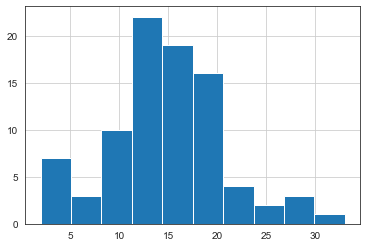

In [6]:
%matplotlib inline
units.groupby('action').count().unit_name.hist()

In [7]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [8]:
first_row = units[units['action'] == '1849-060319-3'].iloc[0]
#first_row = sessions.iloc[50]

In [16]:
def process(row):
    action_id = row['action']
    channel_id = row['channel_group']
    unit_id = row['unit_name']
    
    # common values for all units == faster calculations
    x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
    ang, ang_t = map(data_loader.head_direction(action_id).get, ['a', 't'])
    
    occupancy_map = data_loader.occupancy(action_id)
    xbins, ybins = data_loader.spatial_bins
    box_size_, bin_size_ = data_loader.box_size_, data_loader.bin_size_
    prob_dist = data_loader.prob_dist(action_id)
    
    smooth_low_occupancy_map = sp.maps.smooth_map(
        occupancy_map, bin_size=bin_size_, smoothing=smoothing_low)
    smooth_high_occupancy_map = sp.maps.smooth_map(
        occupancy_map, bin_size=bin_size_, smoothing=smoothing_high)
            
    spike_times = data_loader.spike_train(action_id, channel_id, unit_id)
    if len(spike_times) == 0:
        result = pd.Series({
            'average_rate': np.nan,
            'speed_score': np.nan,
            'out_field_mean_rate': np.nan,
            'in_field_mean_rate': np.nan,
            'max_field_mean_rate': np.nan,
            'max_rate': np.nan,
            'sparsity': np.nan,
            'selectivity': np.nan,
            'interspike_interval_cv': np.nan,
            'burst_event_ratio': np.nan,
            'bursty_spike_ratio': np.nan,
            'gridness': np.nan,
            'border_score': np.nan,
            'information_rate': np.nan,
            'information_specificity': np.nan,
            'head_mean_ang': np.nan,
            'head_mean_vec_len': np.nan,
            'spacing': np.nan,
            'orientation': np.nan,
            'field_area': np.nan,
            'theta_score': np.nan
        })
        return result

    # common
    spike_map = sp.maps._spike_map(x, y, t, spike_times, xbins, ybins)

    smooth_low_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing_low)
    smooth_high_spike_map = sp.maps.smooth_map(spike_map, bin_size=bin_size_, smoothing=smoothing_high)

    smooth_low_rate_map = smooth_low_spike_map / smooth_low_occupancy_map
    smooth_high_rate_map = smooth_high_spike_map / smooth_high_occupancy_map

    # find fields with laplace
    fields_laplace = sp.separate_fields_by_laplace(smooth_high_rate_map)
    fields = fields_laplace.copy() # to be cleaned by Ismakov
    fields_areas = scipy.ndimage.measurements.sum(
        np.ones_like(fields), fields, index=np.arange(fields.max() + 1))
    fields_area = fields_areas[fields]
    fields[fields_area < 9.0] = 0

    # find fields with Ismakov-method
    fields_ismakov, radius = sp.separate_fields_by_distance(smooth_high_rate_map)
    fields_ismakov_real = fields_ismakov * bin_size
    approved_fields = []

    # remove fields not found by both methods
    for point in fields_ismakov:
        field_id = fields[tuple(point)]
        approved_fields.append(field_id)

    for field_id in np.arange(1, fields.max() + 1):
        if not field_id in approved_fields:
            fields[fields == field_id] = 0

    # varying statistics
    average_rate = len(spike_times) / (t.max() - t.min())

    max_rate = smooth_low_rate_map.max()

    out_field_mean_rate = smooth_low_rate_map[np.where(fields == 0)].mean()
    in_field_mean_rate = smooth_low_rate_map[np.where(fields != 0)].mean()
    max_field_mean_rate = smooth_low_rate_map[np.where(fields == 1)].mean()

    interspike_interval = np.diff(spike_times)
    interspike_interval_cv = interspike_interval.std() / interspike_interval.mean()

    autocorrelogram = sp.autocorrelation(smooth_high_rate_map)
    peaks = sp.fields.find_peaks(autocorrelogram)
    real_peaks = peaks * bin_size
    autocorrelogram_box_size = box_size[0] * autocorrelogram.shape[0] / smooth_high_rate_map.shape[0]
    spacing, orientation = sp.spacing_and_orientation(real_peaks, autocorrelogram_box_size)
    orientation *= 180 / np.pi

    selectivity = stats.selectivity(smooth_low_rate_map, prob_dist)

    sparsity = stats.sparsity(smooth_low_rate_map, prob_dist)

    gridness = sp.gridness(smooth_high_rate_map)

    border_score = sp.border_score(smooth_high_rate_map, fields_laplace)

    information_rate = stats.information_rate(smooth_high_rate_map, prob_dist)
    
    information_spec = stats.information_specificity(smooth_high_rate_map, prob_dist)

    single_spikes, bursts, bursty_spikes = spikes.find_bursts(spike_times, threshold=0.01)
    burst_event_ratio = np.sum(bursts) / (np.sum(single_spikes) + np.sum(bursts))
    bursty_spike_ratio = np.sum(bursty_spikes) / (np.sum(bursty_spikes) + np.sum(single_spikes))
    mean_spikes_per_burst = np.sum(bursty_spikes) / np.sum(bursts)

    speed_score = spd.speed_correlation(
        speed, t, spike_times, min_speed=min_speed, max_speed=max_speed)

    ang_bin, ang_rate = head.head_direction_rate(spike_times, ang, ang_t)

    head_mean_ang, head_mean_vec_len = head.head_direction_score(ang_bin, ang_rate)

    result = pd.Series({
        'average_rate': average_rate,
        'speed_score': speed_score,
        'out_field_mean_rate': out_field_mean_rate,
        'in_field_mean_rate': in_field_mean_rate,
        'max_field_mean_rate': max_field_mean_rate,
        'max_rate': max_rate,
        'sparsity': sparsity,
        'selectivity': selectivity,
        'interspike_interval_cv': float(interspike_interval_cv),
        'burst_event_ratio': burst_event_ratio,
        'bursty_spike_ratio': bursty_spike_ratio,
        'gridness': gridness,
        'border_score': border_score,
        'information_rate': information_rate,
        'information_specificity': information_spec,
        'head_mean_ang': head_mean_ang,
        'head_mean_vec_len': head_mean_vec_len,
        'spacing': spacing,
        'orientation': orientation,
        'field_area': fields_areas[fields].mean() * bin_size**2,
        'theta_score': theta_mod_idx(spike_times.times.magnitude, binsize=0.01, time_limit=0.2)
    })
    return result
        
process(first_row)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice.


average_rate                3.168492
speed_score                -0.068927
out_field_mean_rate         1.857990
in_field_mean_rate          5.257561
max_field_mean_rate              NaN
max_rate                   23.006163
sparsity                    0.466751
selectivity                 7.153172
interspike_interval_cv      3.807699
burst_event_ratio           0.398230
bursty_spike_ratio          0.678064
gridness                   -0.466836
border_score                0.029328
information_rate            1.009215
information_specificity     0.317256
head_mean_ang               5.438033
head_mean_vec_len           0.040874
spacing                     0.628784
orientation                69.775141
field_area                  0.412306
theta_score                -0.430279
dtype: float64

In [17]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice.
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: divide by zero encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in log2
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spatial-maps/spatial_maps/stats.py:13: RuntimeWarning: invalid value encountered in multiply
  return (np.nansum(np.ravel(tmp_rate_map * np.log2(tmp_rate_map/avg_rate) *
/home/mikkel/apps/expipe-project/spike-statistics/spike_statistics/core.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return (pk - th)/(pk + th)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: in

In [18]:
output_path = pathlib.Path("output") / "calculate-statistics"
output_path.mkdir(exist_ok=True)

In [19]:
results.to_csv(output_path / "results.csv", index=False)

# Store results in Expipe action

In [20]:
statistics_action = project.require_action("calculate-statistics")

In [21]:
statistics_action.data["results"] = "results.csv"
copy_tree(output_path, str(statistics_action.data_path()))

['/media/storage/expipe/septum-mec/actions/calculate-statistics/data/results.csv']

In [22]:
statistics_action.modules['parameters'] = {
    'max_speed': max_speed,
    'min_speed': min_speed,
    'position_sampling_rate': position_sampling_rate,
    'position_low_pass_frequency': position_low_pass_frequency,
    'box_size': box_size,
    'bin_size': bin_size,
    'smoothing_low': smoothing_low,
    'smoothing_high': smoothing_high,
    'stim_mask': stim_mask,
    'baseline_duration': baseline_duration
}

In [23]:
septum_mec.analysis.registration.store_notebook(statistics_action, "10_calculate_spatial_statistics.ipynb")